In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [26]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [27]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [28]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [40]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [32]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 100
valid_batch_size = 100

num_epochs = 2000
learning_rate = 0.0001

In [33]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.303781
Train Epoch: 1 [400/600 (66%)]	Loss: 2.284953
Train Epoch: 1 [600/600 (100%)]	Loss: 2.343479

Validation set: Average loss: 2.2979, Accuracy: 25/200 (12%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.287193
Train Epoch: 2 [400/600 (66%)]	Loss: 2.343226
Train Epoch: 2 [600/600 (100%)]	Loss: 2.354417

Validation set: Average loss: 2.2971, Accuracy: 25/200 (12%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.29766
Train Epoch: 3 [400/600 (66%)]	Loss: 2.293767
Train Epoch: 3 [600/600 (100%)]	Loss: 2.317859

Validation set: Average loss: 2.2955, Accuracy: 25/200 (12%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.280127
Train Epoch: 4 [400/600 (66%)]	Loss: 2.312059
Train Epoch: 4 [600/600 (100%)]	Loss: 2.358166

Validation set: Average loss: 2.2918, Accuracy: 24/200 (12%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.294755
Train Epoch: 5 [400/600 (66%)]	Loss: 2.290886
Train Epoch: 5 [600/600 (100%)]	Loss: 2.322949

Validation set: Average loss: 2.2871, Accuracy: 23/20

Train Epoch: 42 [600/600 (100%)]	Loss: 2.165267

Validation set: Average loss: 2.1199, Accuracy: 57/200 (28%)

Train Epoch: 43 [200/600 (33%)]	Loss: 2.156076
Train Epoch: 43 [400/600 (66%)]	Loss: 2.164624
Train Epoch: 43 [600/600 (100%)]	Loss: 2.12487

Validation set: Average loss: 2.1172, Accuracy: 57/200 (28%)

Train Epoch: 44 [200/600 (33%)]	Loss: 2.138446
Train Epoch: 44 [400/600 (66%)]	Loss: 2.103895
Train Epoch: 44 [600/600 (100%)]	Loss: 2.153638

Validation set: Average loss: 2.1123, Accuracy: 56/200 (28%)

Train Epoch: 45 [200/600 (33%)]	Loss: 2.128451
Train Epoch: 45 [400/600 (66%)]	Loss: 2.091802
Train Epoch: 45 [600/600 (100%)]	Loss: 2.145184

Validation set: Average loss: 2.1099, Accuracy: 56/200 (28%)

Train Epoch: 46 [200/600 (33%)]	Loss: 2.115937
Train Epoch: 46 [400/600 (66%)]	Loss: 2.099639
Train Epoch: 46 [600/600 (100%)]	Loss: 2.128833

Validation set: Average loss: 2.106, Accuracy: 57/200 (28%)

Train Epoch: 47 [200/600 (33%)]	Loss: 2.133715
Train Epoch: 47 [400/600

Train Epoch: 84 [200/600 (33%)]	Loss: 2.036343
Train Epoch: 84 [400/600 (66%)]	Loss: 1.945187
Train Epoch: 84 [600/600 (100%)]	Loss: 2.022553

Validation set: Average loss: 1.9846, Accuracy: 63/200 (31%)

Train Epoch: 85 [200/600 (33%)]	Loss: 2.002393
Train Epoch: 85 [400/600 (66%)]	Loss: 1.940523
Train Epoch: 85 [600/600 (100%)]	Loss: 1.975464

Validation set: Average loss: 1.9805, Accuracy: 63/200 (31%)

Train Epoch: 86 [200/600 (33%)]	Loss: 2.067635
Train Epoch: 86 [400/600 (66%)]	Loss: 1.974375
Train Epoch: 86 [600/600 (100%)]	Loss: 1.958276

Validation set: Average loss: 1.9779, Accuracy: 64/200 (32%)

Train Epoch: 87 [200/600 (33%)]	Loss: 1.993762
Train Epoch: 87 [400/600 (66%)]	Loss: 2.001843
Train Epoch: 87 [600/600 (100%)]	Loss: 2.006335

Validation set: Average loss: 1.978, Accuracy: 64/200 (32%)

Train Epoch: 88 [200/600 (33%)]	Loss: 2.034528
Train Epoch: 88 [400/600 (66%)]	Loss: 1.975211
Train Epoch: 88 [600/600 (100%)]	Loss: 2.038032

Validation set: Average loss: 1.9744, 

Train Epoch: 124 [200/600 (33%)]	Loss: 1.95387
Train Epoch: 124 [400/600 (66%)]	Loss: 1.842448
Train Epoch: 124 [600/600 (100%)]	Loss: 1.857656

Validation set: Average loss: 1.8772, Accuracy: 66/200 (33%)

Train Epoch: 125 [200/600 (33%)]	Loss: 1.906883
Train Epoch: 125 [400/600 (66%)]	Loss: 1.851946
Train Epoch: 125 [600/600 (100%)]	Loss: 1.847942

Validation set: Average loss: 1.8723, Accuracy: 67/200 (33%)

Train Epoch: 126 [200/600 (33%)]	Loss: 1.922002
Train Epoch: 126 [400/600 (66%)]	Loss: 1.852365
Train Epoch: 126 [600/600 (100%)]	Loss: 1.852914

Validation set: Average loss: 1.8718, Accuracy: 67/200 (33%)

Train Epoch: 127 [200/600 (33%)]	Loss: 1.95533
Train Epoch: 127 [400/600 (66%)]	Loss: 1.869821
Train Epoch: 127 [600/600 (100%)]	Loss: 1.914599

Validation set: Average loss: 1.8666, Accuracy: 65/200 (32%)

Train Epoch: 128 [200/600 (33%)]	Loss: 1.919394
Train Epoch: 128 [400/600 (66%)]	Loss: 1.851874
Train Epoch: 128 [600/600 (100%)]	Loss: 1.894912

Validation set: Average 

Train Epoch: 164 [400/600 (66%)]	Loss: 1.794425
Train Epoch: 164 [600/600 (100%)]	Loss: 1.797299

Validation set: Average loss: 1.77, Accuracy: 73/200 (36%)

Train Epoch: 165 [200/600 (33%)]	Loss: 1.790919
Train Epoch: 165 [400/600 (66%)]	Loss: 1.776346
Train Epoch: 165 [600/600 (100%)]	Loss: 1.799796

Validation set: Average loss: 1.7674, Accuracy: 73/200 (36%)

Train Epoch: 166 [200/600 (33%)]	Loss: 1.849765
Train Epoch: 166 [400/600 (66%)]	Loss: 1.755201
Train Epoch: 166 [600/600 (100%)]	Loss: 1.787071

Validation set: Average loss: 1.7642, Accuracy: 73/200 (36%)

Train Epoch: 167 [200/600 (33%)]	Loss: 1.840128
Train Epoch: 167 [400/600 (66%)]	Loss: 1.827178
Train Epoch: 167 [600/600 (100%)]	Loss: 1.802204

Validation set: Average loss: 1.7574, Accuracy: 75/200 (37%)

Train Epoch: 168 [200/600 (33%)]	Loss: 1.815491
Train Epoch: 168 [400/600 (66%)]	Loss: 1.759494
Train Epoch: 168 [600/600 (100%)]	Loss: 1.740526

Validation set: Average loss: 1.7605, Accuracy: 73/200 (36%)

Train Epoc

Train Epoch: 205 [200/600 (33%)]	Loss: 1.74624
Train Epoch: 205 [400/600 (66%)]	Loss: 1.703544
Train Epoch: 205 [600/600 (100%)]	Loss: 1.681268

Validation set: Average loss: 1.6669, Accuracy: 76/200 (38%)

Train Epoch: 206 [200/600 (33%)]	Loss: 1.708634
Train Epoch: 206 [400/600 (66%)]	Loss: 1.676407
Train Epoch: 206 [600/600 (100%)]	Loss: 1.707581

Validation set: Average loss: 1.6548, Accuracy: 75/200 (37%)

Train Epoch: 207 [200/600 (33%)]	Loss: 1.763508
Train Epoch: 207 [400/600 (66%)]	Loss: 1.701116
Train Epoch: 207 [600/600 (100%)]	Loss: 1.638741

Validation set: Average loss: 1.6558, Accuracy: 76/200 (38%)

Train Epoch: 208 [200/600 (33%)]	Loss: 1.776231
Train Epoch: 208 [400/600 (66%)]	Loss: 1.66341
Train Epoch: 208 [600/600 (100%)]	Loss: 1.633231

Validation set: Average loss: 1.6593, Accuracy: 77/200 (38%)

Train Epoch: 209 [200/600 (33%)]	Loss: 1.785324
Train Epoch: 209 [400/600 (66%)]	Loss: 1.690084
Train Epoch: 209 [600/600 (100%)]	Loss: 1.723795

Validation set: Average 


Validation set: Average loss: 1.5662, Accuracy: 84/200 (42%)

Train Epoch: 245 [200/600 (33%)]	Loss: 1.65108
Train Epoch: 245 [400/600 (66%)]	Loss: 1.612237
Train Epoch: 245 [600/600 (100%)]	Loss: 1.588746

Validation set: Average loss: 1.5616, Accuracy: 83/200 (41%)

Train Epoch: 246 [200/600 (33%)]	Loss: 1.653503
Train Epoch: 246 [400/600 (66%)]	Loss: 1.592256
Train Epoch: 246 [600/600 (100%)]	Loss: 1.593795

Validation set: Average loss: 1.5638, Accuracy: 84/200 (42%)

Train Epoch: 247 [200/600 (33%)]	Loss: 1.645055
Train Epoch: 247 [400/600 (66%)]	Loss: 1.584184
Train Epoch: 247 [600/600 (100%)]	Loss: 1.621904

Validation set: Average loss: 1.5621, Accuracy: 85/200 (42%)

Train Epoch: 248 [200/600 (33%)]	Loss: 1.656473
Train Epoch: 248 [400/600 (66%)]	Loss: 1.586476
Train Epoch: 248 [600/600 (100%)]	Loss: 1.581102

Validation set: Average loss: 1.5614, Accuracy: 86/200 (43%)

Train Epoch: 249 [200/600 (33%)]	Loss: 1.61956
Train Epoch: 249 [400/600 (66%)]	Loss: 1.609606
Train Epoch

Train Epoch: 285 [200/600 (33%)]	Loss: 1.658358
Train Epoch: 285 [400/600 (66%)]	Loss: 1.487836
Train Epoch: 285 [600/600 (100%)]	Loss: 1.543068

Validation set: Average loss: 1.4707, Accuracy: 97/200 (48%)

Train Epoch: 286 [200/600 (33%)]	Loss: 1.502809
Train Epoch: 286 [400/600 (66%)]	Loss: 1.422666
Train Epoch: 286 [600/600 (100%)]	Loss: 1.630243

Validation set: Average loss: 1.4678, Accuracy: 96/200 (48%)

Train Epoch: 287 [200/600 (33%)]	Loss: 1.515428
Train Epoch: 287 [400/600 (66%)]	Loss: 1.519817
Train Epoch: 287 [600/600 (100%)]	Loss: 1.542432

Validation set: Average loss: 1.4685, Accuracy: 97/200 (48%)

Train Epoch: 288 [200/600 (33%)]	Loss: 1.556139
Train Epoch: 288 [400/600 (66%)]	Loss: 1.517981
Train Epoch: 288 [600/600 (100%)]	Loss: 1.501834

Validation set: Average loss: 1.4621, Accuracy: 98/200 (49%)

Train Epoch: 289 [200/600 (33%)]	Loss: 1.612495
Train Epoch: 289 [400/600 (66%)]	Loss: 1.510563
Train Epoch: 289 [600/600 (100%)]	Loss: 1.499202

Validation set: Averag

Train Epoch: 325 [400/600 (66%)]	Loss: 1.405984
Train Epoch: 325 [600/600 (100%)]	Loss: 1.454696

Validation set: Average loss: 1.3814, Accuracy: 108/200 (54%)

Train Epoch: 326 [200/600 (33%)]	Loss: 1.495174
Train Epoch: 326 [400/600 (66%)]	Loss: 1.371977
Train Epoch: 326 [600/600 (100%)]	Loss: 1.373121

Validation set: Average loss: 1.3763, Accuracy: 109/200 (54%)

Train Epoch: 327 [200/600 (33%)]	Loss: 1.490917
Train Epoch: 327 [400/600 (66%)]	Loss: 1.423895
Train Epoch: 327 [600/600 (100%)]	Loss: 1.418769

Validation set: Average loss: 1.3752, Accuracy: 107/200 (53%)

Train Epoch: 328 [200/600 (33%)]	Loss: 1.438075
Train Epoch: 328 [400/600 (66%)]	Loss: 1.439153
Train Epoch: 328 [600/600 (100%)]	Loss: 1.468984

Validation set: Average loss: 1.3688, Accuracy: 109/200 (54%)

Train Epoch: 329 [200/600 (33%)]	Loss: 1.464685
Train Epoch: 329 [400/600 (66%)]	Loss: 1.359128
Train Epoch: 329 [600/600 (100%)]	Loss: 1.333035

Validation set: Average loss: 1.3646, Accuracy: 108/200 (54%)

Tra

Train Epoch: 366 [600/600 (100%)]	Loss: 1.388044

Validation set: Average loss: 1.2991, Accuracy: 110/200 (55%)

Train Epoch: 367 [200/600 (33%)]	Loss: 1.379715
Train Epoch: 367 [400/600 (66%)]	Loss: 1.322342
Train Epoch: 367 [600/600 (100%)]	Loss: 1.321024

Validation set: Average loss: 1.2935, Accuracy: 112/200 (56%)

Train Epoch: 368 [200/600 (33%)]	Loss: 1.475561
Train Epoch: 368 [400/600 (66%)]	Loss: 1.330529
Train Epoch: 368 [600/600 (100%)]	Loss: 1.326346

Validation set: Average loss: 1.2935, Accuracy: 113/200 (56%)

Train Epoch: 369 [200/600 (33%)]	Loss: 1.394336
Train Epoch: 369 [400/600 (66%)]	Loss: 1.287324
Train Epoch: 369 [600/600 (100%)]	Loss: 1.335806

Validation set: Average loss: 1.2922, Accuracy: 112/200 (56%)

Train Epoch: 370 [200/600 (33%)]	Loss: 1.363009
Train Epoch: 370 [400/600 (66%)]	Loss: 1.385966
Train Epoch: 370 [600/600 (100%)]	Loss: 1.372243

Validation set: Average loss: 1.2883, Accuracy: 113/200 (56%)

Train Epoch: 371 [200/600 (33%)]	Loss: 1.405702
Tra

Train Epoch: 409 [200/600 (33%)]	Loss: 1.35381
Train Epoch: 409 [400/600 (66%)]	Loss: 1.205808
Train Epoch: 409 [600/600 (100%)]	Loss: 1.238768

Validation set: Average loss: 1.2274, Accuracy: 120/200 (60%)

Train Epoch: 410 [200/600 (33%)]	Loss: 1.368312
Train Epoch: 410 [400/600 (66%)]	Loss: 1.2417
Train Epoch: 410 [600/600 (100%)]	Loss: 1.312397

Validation set: Average loss: 1.2244, Accuracy: 120/200 (60%)

Train Epoch: 411 [200/600 (33%)]	Loss: 1.36872
Train Epoch: 411 [400/600 (66%)]	Loss: 1.187965
Train Epoch: 411 [600/600 (100%)]	Loss: 1.205745

Validation set: Average loss: 1.2254, Accuracy: 119/200 (59%)

Train Epoch: 412 [200/600 (33%)]	Loss: 1.265226
Train Epoch: 412 [400/600 (66%)]	Loss: 1.354892
Train Epoch: 412 [600/600 (100%)]	Loss: 1.26589

Validation set: Average loss: 1.2245, Accuracy: 120/200 (60%)

Train Epoch: 413 [200/600 (33%)]	Loss: 1.382182
Train Epoch: 413 [400/600 (66%)]	Loss: 1.282283
Train Epoch: 413 [600/600 (100%)]	Loss: 1.198232

Validation set: Average


Validation set: Average loss: 1.1772, Accuracy: 123/200 (61%)

Train Epoch: 451 [200/600 (33%)]	Loss: 1.256716
Train Epoch: 451 [400/600 (66%)]	Loss: 1.094098
Train Epoch: 451 [600/600 (100%)]	Loss: 1.213808

Validation set: Average loss: 1.1769, Accuracy: 124/200 (62%)

Train Epoch: 452 [200/600 (33%)]	Loss: 1.123914
Train Epoch: 452 [400/600 (66%)]	Loss: 1.187642
Train Epoch: 452 [600/600 (100%)]	Loss: 1.210833

Validation set: Average loss: 1.1744, Accuracy: 120/200 (60%)

Train Epoch: 453 [200/600 (33%)]	Loss: 1.195005
Train Epoch: 453 [400/600 (66%)]	Loss: 1.255666
Train Epoch: 453 [600/600 (100%)]	Loss: 1.25519

Validation set: Average loss: 1.1757, Accuracy: 122/200 (61%)

Train Epoch: 454 [200/600 (33%)]	Loss: 1.15589
Train Epoch: 454 [400/600 (66%)]	Loss: 1.197732
Train Epoch: 454 [600/600 (100%)]	Loss: 1.208074

Validation set: Average loss: 1.1739, Accuracy: 121/200 (60%)

Train Epoch: 455 [200/600 (33%)]	Loss: 1.29124
Train Epoch: 455 [400/600 (66%)]	Loss: 1.231991
Train E

Train Epoch: 490 [600/600 (100%)]	Loss: 1.088571

Validation set: Average loss: 1.1407, Accuracy: 122/200 (61%)

Train Epoch: 491 [200/600 (33%)]	Loss: 1.192677
Train Epoch: 491 [400/600 (66%)]	Loss: 1.14833
Train Epoch: 491 [600/600 (100%)]	Loss: 1.167345

Validation set: Average loss: 1.1403, Accuracy: 124/200 (62%)

Train Epoch: 492 [200/600 (33%)]	Loss: 1.212955
Train Epoch: 492 [400/600 (66%)]	Loss: 1.165254
Train Epoch: 492 [600/600 (100%)]	Loss: 1.102213

Validation set: Average loss: 1.1393, Accuracy: 123/200 (61%)

Train Epoch: 493 [200/600 (33%)]	Loss: 1.018213
Train Epoch: 493 [400/600 (66%)]	Loss: 1.117084
Train Epoch: 493 [600/600 (100%)]	Loss: 1.103184

Validation set: Average loss: 1.1371, Accuracy: 123/200 (61%)

Train Epoch: 494 [200/600 (33%)]	Loss: 1.092905
Train Epoch: 494 [400/600 (66%)]	Loss: 1.228579
Train Epoch: 494 [600/600 (100%)]	Loss: 1.03733

Validation set: Average loss: 1.1369, Accuracy: 123/200 (61%)

Train Epoch: 495 [200/600 (33%)]	Loss: 1.197514
Train

Train Epoch: 531 [200/600 (33%)]	Loss: 1.135782
Train Epoch: 531 [400/600 (66%)]	Loss: 1.040202
Train Epoch: 531 [600/600 (100%)]	Loss: 1.01483

Validation set: Average loss: 1.1022, Accuracy: 125/200 (62%)

Train Epoch: 532 [200/600 (33%)]	Loss: 1.178687
Train Epoch: 532 [400/600 (66%)]	Loss: 1.107648
Train Epoch: 532 [600/600 (100%)]	Loss: 1.116769

Validation set: Average loss: 1.1021, Accuracy: 125/200 (62%)

Train Epoch: 533 [200/600 (33%)]	Loss: 1.090243
Train Epoch: 533 [400/600 (66%)]	Loss: 1.068231
Train Epoch: 533 [600/600 (100%)]	Loss: 1.143458

Validation set: Average loss: 1.1034, Accuracy: 125/200 (62%)

Train Epoch: 534 [200/600 (33%)]	Loss: 1.104756
Train Epoch: 534 [400/600 (66%)]	Loss: 1.121553
Train Epoch: 534 [600/600 (100%)]	Loss: 1.05916

Validation set: Average loss: 1.1027, Accuracy: 125/200 (62%)

Train Epoch: 535 [200/600 (33%)]	Loss: 1.157319
Train Epoch: 535 [400/600 (66%)]	Loss: 1.174602
Train Epoch: 535 [600/600 (100%)]	Loss: 1.032019

Validation set: Aver

Train Epoch: 571 [600/600 (100%)]	Loss: 1.140495

Validation set: Average loss: 1.0785, Accuracy: 125/200 (62%)

Train Epoch: 572 [200/600 (33%)]	Loss: 1.075223
Train Epoch: 572 [400/600 (66%)]	Loss: 1.188645
Train Epoch: 572 [600/600 (100%)]	Loss: 1.08615

Validation set: Average loss: 1.0765, Accuracy: 127/200 (63%)

Train Epoch: 573 [200/600 (33%)]	Loss: 1.022486
Train Epoch: 573 [400/600 (66%)]	Loss: 0.969048
Train Epoch: 573 [600/600 (100%)]	Loss: 0.980753

Validation set: Average loss: 1.0759, Accuracy: 125/200 (62%)

Train Epoch: 574 [200/600 (33%)]	Loss: 1.086975
Train Epoch: 574 [400/600 (66%)]	Loss: 1.054086
Train Epoch: 574 [600/600 (100%)]	Loss: 1.094364

Validation set: Average loss: 1.0759, Accuracy: 126/200 (63%)

Train Epoch: 575 [200/600 (33%)]	Loss: 0.952739
Train Epoch: 575 [400/600 (66%)]	Loss: 0.966855
Train Epoch: 575 [600/600 (100%)]	Loss: 1.032083

Validation set: Average loss: 1.0729, Accuracy: 126/200 (63%)

Train Epoch: 576 [200/600 (33%)]	Loss: 0.964374
Trai

Train Epoch: 613 [200/600 (33%)]	Loss: 1.121149
Train Epoch: 613 [400/600 (66%)]	Loss: 0.997383
Train Epoch: 613 [600/600 (100%)]	Loss: 0.898138

Validation set: Average loss: 1.061, Accuracy: 129/200 (64%)

Train Epoch: 614 [200/600 (33%)]	Loss: 1.021323
Train Epoch: 614 [400/600 (66%)]	Loss: 0.949124
Train Epoch: 614 [600/600 (100%)]	Loss: 0.981994

Validation set: Average loss: 1.0623, Accuracy: 129/200 (64%)

Train Epoch: 615 [200/600 (33%)]	Loss: 0.979247
Train Epoch: 615 [400/600 (66%)]	Loss: 0.91985
Train Epoch: 615 [600/600 (100%)]	Loss: 0.893774

Validation set: Average loss: 1.0579, Accuracy: 130/200 (65%)

Train Epoch: 616 [200/600 (33%)]	Loss: 1.039945
Train Epoch: 616 [400/600 (66%)]	Loss: 1.003217
Train Epoch: 616 [600/600 (100%)]	Loss: 0.937668

Validation set: Average loss: 1.0577, Accuracy: 130/200 (65%)

Train Epoch: 617 [200/600 (33%)]	Loss: 0.938907
Train Epoch: 617 [400/600 (66%)]	Loss: 0.855696
Train Epoch: 617 [600/600 (100%)]	Loss: 0.969644

Validation set: Aver

Train Epoch: 653 [400/600 (66%)]	Loss: 0.919319
Train Epoch: 653 [600/600 (100%)]	Loss: 0.983205

Validation set: Average loss: 1.0415, Accuracy: 129/200 (64%)

Train Epoch: 654 [200/600 (33%)]	Loss: 0.969876
Train Epoch: 654 [400/600 (66%)]	Loss: 0.997335
Train Epoch: 654 [600/600 (100%)]	Loss: 0.912706

Validation set: Average loss: 1.0422, Accuracy: 131/200 (65%)

Train Epoch: 655 [200/600 (33%)]	Loss: 1.130887
Train Epoch: 655 [400/600 (66%)]	Loss: 0.950741
Train Epoch: 655 [600/600 (100%)]	Loss: 0.946499

Validation set: Average loss: 1.039, Accuracy: 130/200 (65%)

Train Epoch: 656 [200/600 (33%)]	Loss: 0.875071
Train Epoch: 656 [400/600 (66%)]	Loss: 0.885958
Train Epoch: 656 [600/600 (100%)]	Loss: 0.954828

Validation set: Average loss: 1.0386, Accuracy: 128/200 (64%)

Train Epoch: 657 [200/600 (33%)]	Loss: 1.00876
Train Epoch: 657 [400/600 (66%)]	Loss: 0.919936
Train Epoch: 657 [600/600 (100%)]	Loss: 0.959495

Validation set: Average loss: 1.0404, Accuracy: 128/200 (64%)

Train

Train Epoch: 694 [600/600 (100%)]	Loss: 0.889181

Validation set: Average loss: 1.0287, Accuracy: 130/200 (65%)

Train Epoch: 695 [200/600 (33%)]	Loss: 1.019336
Train Epoch: 695 [400/600 (66%)]	Loss: 0.881496
Train Epoch: 695 [600/600 (100%)]	Loss: 0.891792

Validation set: Average loss: 1.0273, Accuracy: 131/200 (65%)

Train Epoch: 696 [200/600 (33%)]	Loss: 1.064056
Train Epoch: 696 [400/600 (66%)]	Loss: 0.855304
Train Epoch: 696 [600/600 (100%)]	Loss: 0.917221

Validation set: Average loss: 1.0258, Accuracy: 130/200 (65%)

Train Epoch: 697 [200/600 (33%)]	Loss: 0.943974
Train Epoch: 697 [400/600 (66%)]	Loss: 0.957584
Train Epoch: 697 [600/600 (100%)]	Loss: 0.947612

Validation set: Average loss: 1.0244, Accuracy: 132/200 (66%)

Train Epoch: 698 [200/600 (33%)]	Loss: 0.949835
Train Epoch: 698 [400/600 (66%)]	Loss: 0.832044
Train Epoch: 698 [600/600 (100%)]	Loss: 0.87687

Validation set: Average loss: 1.0245, Accuracy: 131/200 (65%)

Train Epoch: 699 [200/600 (33%)]	Loss: 1.075164
Trai

Train Epoch: 735 [600/600 (100%)]	Loss: 0.880408

Validation set: Average loss: 1.0191, Accuracy: 130/200 (65%)

Train Epoch: 736 [200/600 (33%)]	Loss: 0.873208
Train Epoch: 736 [400/600 (66%)]	Loss: 0.97288
Train Epoch: 736 [600/600 (100%)]	Loss: 0.96379

Validation set: Average loss: 1.0211, Accuracy: 132/200 (66%)

Train Epoch: 737 [200/600 (33%)]	Loss: 0.976812
Train Epoch: 737 [400/600 (66%)]	Loss: 0.872316
Train Epoch: 737 [600/600 (100%)]	Loss: 0.894785

Validation set: Average loss: 1.023, Accuracy: 134/200 (67%)

Train Epoch: 738 [200/600 (33%)]	Loss: 0.932568
Train Epoch: 738 [400/600 (66%)]	Loss: 1.042643
Train Epoch: 738 [600/600 (100%)]	Loss: 0.92565

Validation set: Average loss: 1.0225, Accuracy: 132/200 (66%)

Train Epoch: 739 [200/600 (33%)]	Loss: 0.83938
Train Epoch: 739 [400/600 (66%)]	Loss: 0.910311
Train Epoch: 739 [600/600 (100%)]	Loss: 0.693177

Validation set: Average loss: 1.0263, Accuracy: 133/200 (66%)

Train Epoch: 740 [200/600 (33%)]	Loss: 1.056131
Train Ep

Train Epoch: 775 [600/600 (100%)]	Loss: 0.899459

Validation set: Average loss: 1.0178, Accuracy: 132/200 (66%)

Train Epoch: 776 [200/600 (33%)]	Loss: 0.779326
Train Epoch: 776 [400/600 (66%)]	Loss: 0.789315
Train Epoch: 776 [600/600 (100%)]	Loss: 0.832068

Validation set: Average loss: 1.0198, Accuracy: 132/200 (66%)

Train Epoch: 777 [200/600 (33%)]	Loss: 0.789758
Train Epoch: 777 [400/600 (66%)]	Loss: 0.844458
Train Epoch: 777 [600/600 (100%)]	Loss: 0.824654

Validation set: Average loss: 1.0164, Accuracy: 133/200 (66%)

Train Epoch: 778 [200/600 (33%)]	Loss: 0.912335
Train Epoch: 778 [400/600 (66%)]	Loss: 0.869043
Train Epoch: 778 [600/600 (100%)]	Loss: 0.937647

Validation set: Average loss: 1.0158, Accuracy: 132/200 (66%)

Train Epoch: 779 [200/600 (33%)]	Loss: 0.947092
Train Epoch: 779 [400/600 (66%)]	Loss: 0.938437
Train Epoch: 779 [600/600 (100%)]	Loss: 0.832305

Validation set: Average loss: 1.0125, Accuracy: 132/200 (66%)

Train Epoch: 780 [200/600 (33%)]	Loss: 0.851301
Tra

Train Epoch: 815 [400/600 (66%)]	Loss: 0.865242
Train Epoch: 815 [600/600 (100%)]	Loss: 0.806582

Validation set: Average loss: 1.0028, Accuracy: 133/200 (66%)

Train Epoch: 816 [200/600 (33%)]	Loss: 0.730293
Train Epoch: 816 [400/600 (66%)]	Loss: 0.800955
Train Epoch: 816 [600/600 (100%)]	Loss: 0.977043

Validation set: Average loss: 1.005, Accuracy: 132/200 (66%)

Train Epoch: 817 [200/600 (33%)]	Loss: 0.833017
Train Epoch: 817 [400/600 (66%)]	Loss: 0.784762
Train Epoch: 817 [600/600 (100%)]	Loss: 1.017073

Validation set: Average loss: 1.0068, Accuracy: 132/200 (66%)

Train Epoch: 818 [200/600 (33%)]	Loss: 0.87009
Train Epoch: 818 [400/600 (66%)]	Loss: 0.846158
Train Epoch: 818 [600/600 (100%)]	Loss: 0.791943

Validation set: Average loss: 1.0073, Accuracy: 133/200 (66%)

Train Epoch: 819 [200/600 (33%)]	Loss: 0.713026
Train Epoch: 819 [400/600 (66%)]	Loss: 0.814258
Train Epoch: 819 [600/600 (100%)]	Loss: 0.760936

Validation set: Average loss: 1.0076, Accuracy: 133/200 (66%)

Train

Train Epoch: 855 [400/600 (66%)]	Loss: 0.750971
Train Epoch: 855 [600/600 (100%)]	Loss: 0.866687

Validation set: Average loss: 0.9979, Accuracy: 134/200 (67%)

Train Epoch: 856 [200/600 (33%)]	Loss: 0.805719
Train Epoch: 856 [400/600 (66%)]	Loss: 0.705937
Train Epoch: 856 [600/600 (100%)]	Loss: 0.896164

Validation set: Average loss: 0.9973, Accuracy: 133/200 (66%)

Train Epoch: 857 [200/600 (33%)]	Loss: 0.84534
Train Epoch: 857 [400/600 (66%)]	Loss: 0.815187
Train Epoch: 857 [600/600 (100%)]	Loss: 0.800853

Validation set: Average loss: 0.9964, Accuracy: 133/200 (66%)

Train Epoch: 858 [200/600 (33%)]	Loss: 0.888689
Train Epoch: 858 [400/600 (66%)]	Loss: 0.770686
Train Epoch: 858 [600/600 (100%)]	Loss: 0.742966

Validation set: Average loss: 1.0013, Accuracy: 134/200 (67%)

Train Epoch: 859 [200/600 (33%)]	Loss: 0.769424
Train Epoch: 859 [400/600 (66%)]	Loss: 0.766738
Train Epoch: 859 [600/600 (100%)]	Loss: 0.800795

Validation set: Average loss: 1.0014, Accuracy: 134/200 (67%)

Trai

Train Epoch: 895 [200/600 (33%)]	Loss: 0.91236
Train Epoch: 895 [400/600 (66%)]	Loss: 0.747088
Train Epoch: 895 [600/600 (100%)]	Loss: 0.820025

Validation set: Average loss: 1.0051, Accuracy: 134/200 (67%)

Train Epoch: 896 [200/600 (33%)]	Loss: 0.826961
Train Epoch: 896 [400/600 (66%)]	Loss: 0.797457
Train Epoch: 896 [600/600 (100%)]	Loss: 0.65828

Validation set: Average loss: 1.0057, Accuracy: 133/200 (66%)

Train Epoch: 897 [200/600 (33%)]	Loss: 0.818255
Train Epoch: 897 [400/600 (66%)]	Loss: 0.719013
Train Epoch: 897 [600/600 (100%)]	Loss: 0.768852

Validation set: Average loss: 1.0041, Accuracy: 133/200 (66%)

Train Epoch: 898 [200/600 (33%)]	Loss: 0.718662
Train Epoch: 898 [400/600 (66%)]	Loss: 0.689113
Train Epoch: 898 [600/600 (100%)]	Loss: 0.650224

Validation set: Average loss: 0.9984, Accuracy: 132/200 (66%)

Train Epoch: 899 [200/600 (33%)]	Loss: 0.817549
Train Epoch: 899 [400/600 (66%)]	Loss: 0.748359
Train Epoch: 899 [600/600 (100%)]	Loss: 0.773427

Validation set: Aver

Train Epoch: 938 [400/600 (66%)]	Loss: 0.702619
Train Epoch: 938 [600/600 (100%)]	Loss: 0.729686

Validation set: Average loss: 1.0039, Accuracy: 133/200 (66%)

Train Epoch: 939 [200/600 (33%)]	Loss: 0.687572
Train Epoch: 939 [400/600 (66%)]	Loss: 0.742028
Train Epoch: 939 [600/600 (100%)]	Loss: 0.643472

Validation set: Average loss: 1.0066, Accuracy: 133/200 (66%)

Train Epoch: 940 [200/600 (33%)]	Loss: 0.730906
Train Epoch: 940 [400/600 (66%)]	Loss: 0.949413
Train Epoch: 940 [600/600 (100%)]	Loss: 0.79772

Validation set: Average loss: 1.0036, Accuracy: 134/200 (67%)

Train Epoch: 941 [200/600 (33%)]	Loss: 0.722674
Train Epoch: 941 [400/600 (66%)]	Loss: 0.711481
Train Epoch: 941 [600/600 (100%)]	Loss: 0.849657

Validation set: Average loss: 1.0073, Accuracy: 133/200 (66%)

Train Epoch: 942 [200/600 (33%)]	Loss: 0.786807
Train Epoch: 942 [400/600 (66%)]	Loss: 0.72754
Train Epoch: 942 [600/600 (100%)]	Loss: 0.703963

Validation set: Average loss: 1.0072, Accuracy: 133/200 (66%)

Train

Train Epoch: 978 [400/600 (66%)]	Loss: 0.797696
Train Epoch: 978 [600/600 (100%)]	Loss: 0.670759

Validation set: Average loss: 1.0025, Accuracy: 131/200 (65%)

Train Epoch: 979 [200/600 (33%)]	Loss: 0.686399
Train Epoch: 979 [400/600 (66%)]	Loss: 0.708507
Train Epoch: 979 [600/600 (100%)]	Loss: 0.785517

Validation set: Average loss: 1.0052, Accuracy: 131/200 (65%)

Train Epoch: 980 [200/600 (33%)]	Loss: 0.616167
Train Epoch: 980 [400/600 (66%)]	Loss: 0.775616
Train Epoch: 980 [600/600 (100%)]	Loss: 0.722948

Validation set: Average loss: 1.0056, Accuracy: 133/200 (66%)

Train Epoch: 981 [200/600 (33%)]	Loss: 0.725965
Train Epoch: 981 [400/600 (66%)]	Loss: 0.725788
Train Epoch: 981 [600/600 (100%)]	Loss: 0.738501

Validation set: Average loss: 1.0026, Accuracy: 133/200 (66%)

Train Epoch: 982 [200/600 (33%)]	Loss: 0.557035
Train Epoch: 982 [400/600 (66%)]	Loss: 0.730101
Train Epoch: 982 [600/600 (100%)]	Loss: 0.818404

Validation set: Average loss: 1.0035, Accuracy: 135/200 (67%)

Tra

Train Epoch: 1021 [600/600 (100%)]	Loss: 0.7713

Validation set: Average loss: 1.0094, Accuracy: 136/200 (68%)

Train Epoch: 1022 [200/600 (33%)]	Loss: 0.633048
Train Epoch: 1022 [400/600 (66%)]	Loss: 0.595782
Train Epoch: 1022 [600/600 (100%)]	Loss: 0.709738

Validation set: Average loss: 1.0109, Accuracy: 136/200 (68%)

Train Epoch: 1023 [200/600 (33%)]	Loss: 0.770882
Train Epoch: 1023 [400/600 (66%)]	Loss: 0.634353
Train Epoch: 1023 [600/600 (100%)]	Loss: 0.71254

Validation set: Average loss: 1.0137, Accuracy: 134/200 (67%)

Train Epoch: 1024 [200/600 (33%)]	Loss: 0.75712
Train Epoch: 1024 [400/600 (66%)]	Loss: 0.652407
Train Epoch: 1024 [600/600 (100%)]	Loss: 0.678721

Validation set: Average loss: 1.0132, Accuracy: 135/200 (67%)

Train Epoch: 1025 [200/600 (33%)]	Loss: 0.751668
Train Epoch: 1025 [400/600 (66%)]	Loss: 0.771568
Train Epoch: 1025 [600/600 (100%)]	Loss: 0.651667

Validation set: Average loss: 1.0189, Accuracy: 135/200 (67%)

Train Epoch: 1026 [200/600 (33%)]	Loss: 0.

Train Epoch: 1060 [600/600 (100%)]	Loss: 0.669884

Validation set: Average loss: 1.0261, Accuracy: 135/200 (67%)

Train Epoch: 1061 [200/600 (33%)]	Loss: 0.607795
Train Epoch: 1061 [400/600 (66%)]	Loss: 0.77413
Train Epoch: 1061 [600/600 (100%)]	Loss: 0.642686

Validation set: Average loss: 1.0223, Accuracy: 135/200 (67%)

Train Epoch: 1062 [200/600 (33%)]	Loss: 0.669935
Train Epoch: 1062 [400/600 (66%)]	Loss: 0.671424
Train Epoch: 1062 [600/600 (100%)]	Loss: 0.632151

Validation set: Average loss: 1.0248, Accuracy: 134/200 (67%)

Train Epoch: 1063 [200/600 (33%)]	Loss: 0.637194
Train Epoch: 1063 [400/600 (66%)]	Loss: 0.628032
Train Epoch: 1063 [600/600 (100%)]	Loss: 0.730685

Validation set: Average loss: 1.0238, Accuracy: 134/200 (67%)

Train Epoch: 1064 [200/600 (33%)]	Loss: 0.660657
Train Epoch: 1064 [400/600 (66%)]	Loss: 0.663232
Train Epoch: 1064 [600/600 (100%)]	Loss: 0.678699

Validation set: Average loss: 1.0208, Accuracy: 134/200 (67%)

Train Epoch: 1065 [200/600 (33%)]	Loss:

Train Epoch: 1101 [400/600 (66%)]	Loss: 0.712733
Train Epoch: 1101 [600/600 (100%)]	Loss: 0.771443

Validation set: Average loss: 1.015, Accuracy: 134/200 (67%)

Train Epoch: 1102 [200/600 (33%)]	Loss: 0.581616
Train Epoch: 1102 [400/600 (66%)]	Loss: 0.637305
Train Epoch: 1102 [600/600 (100%)]	Loss: 0.735708

Validation set: Average loss: 1.0144, Accuracy: 134/200 (67%)

Train Epoch: 1103 [200/600 (33%)]	Loss: 0.526277
Train Epoch: 1103 [400/600 (66%)]	Loss: 0.681965
Train Epoch: 1103 [600/600 (100%)]	Loss: 0.715562

Validation set: Average loss: 1.022, Accuracy: 133/200 (66%)

Train Epoch: 1104 [200/600 (33%)]	Loss: 0.698642
Train Epoch: 1104 [400/600 (66%)]	Loss: 0.64778
Train Epoch: 1104 [600/600 (100%)]	Loss: 0.696383

Validation set: Average loss: 1.0206, Accuracy: 134/200 (67%)

Train Epoch: 1105 [200/600 (33%)]	Loss: 0.530687
Train Epoch: 1105 [400/600 (66%)]	Loss: 0.607083
Train Epoch: 1105 [600/600 (100%)]	Loss: 0.717066

Validation set: Average loss: 1.0206, Accuracy: 133/200

Train Epoch: 1141 [400/600 (66%)]	Loss: 0.58909
Train Epoch: 1141 [600/600 (100%)]	Loss: 0.620667

Validation set: Average loss: 1.0328, Accuracy: 133/200 (66%)

Train Epoch: 1142 [200/600 (33%)]	Loss: 0.693576
Train Epoch: 1142 [400/600 (66%)]	Loss: 0.623683
Train Epoch: 1142 [600/600 (100%)]	Loss: 0.692355

Validation set: Average loss: 1.0375, Accuracy: 133/200 (66%)

Train Epoch: 1143 [200/600 (33%)]	Loss: 0.55216
Train Epoch: 1143 [400/600 (66%)]	Loss: 0.610271
Train Epoch: 1143 [600/600 (100%)]	Loss: 0.508733

Validation set: Average loss: 1.0364, Accuracy: 133/200 (66%)

Train Epoch: 1144 [200/600 (33%)]	Loss: 0.59022
Train Epoch: 1144 [400/600 (66%)]	Loss: 0.607266
Train Epoch: 1144 [600/600 (100%)]	Loss: 0.612286

Validation set: Average loss: 1.036, Accuracy: 132/200 (66%)

Train Epoch: 1145 [200/600 (33%)]	Loss: 0.664535
Train Epoch: 1145 [400/600 (66%)]	Loss: 0.531467
Train Epoch: 1145 [600/600 (100%)]	Loss: 0.564616

Validation set: Average loss: 1.0386, Accuracy: 133/200 

Train Epoch: 1180 [400/600 (66%)]	Loss: 0.585459
Train Epoch: 1180 [600/600 (100%)]	Loss: 0.517564

Validation set: Average loss: 1.032, Accuracy: 133/200 (66%)

Train Epoch: 1181 [200/600 (33%)]	Loss: 0.577004
Train Epoch: 1181 [400/600 (66%)]	Loss: 0.668228
Train Epoch: 1181 [600/600 (100%)]	Loss: 0.598594

Validation set: Average loss: 1.0273, Accuracy: 133/200 (66%)

Train Epoch: 1182 [200/600 (33%)]	Loss: 0.59664
Train Epoch: 1182 [400/600 (66%)]	Loss: 0.494604
Train Epoch: 1182 [600/600 (100%)]	Loss: 0.589694

Validation set: Average loss: 1.032, Accuracy: 133/200 (66%)

Train Epoch: 1183 [200/600 (33%)]	Loss: 0.607485
Train Epoch: 1183 [400/600 (66%)]	Loss: 0.805795
Train Epoch: 1183 [600/600 (100%)]	Loss: 0.546883

Validation set: Average loss: 1.0398, Accuracy: 132/200 (66%)

Train Epoch: 1184 [200/600 (33%)]	Loss: 0.587622
Train Epoch: 1184 [400/600 (66%)]	Loss: 0.660474
Train Epoch: 1184 [600/600 (100%)]	Loss: 0.582784

Validation set: Average loss: 1.03, Accuracy: 132/200 (

Train Epoch: 1219 [200/600 (33%)]	Loss: 0.571262
Train Epoch: 1219 [400/600 (66%)]	Loss: 0.661632
Train Epoch: 1219 [600/600 (100%)]	Loss: 0.599119

Validation set: Average loss: 1.0429, Accuracy: 133/200 (66%)

Train Epoch: 1220 [200/600 (33%)]	Loss: 0.603986
Train Epoch: 1220 [400/600 (66%)]	Loss: 0.493649
Train Epoch: 1220 [600/600 (100%)]	Loss: 0.633745

Validation set: Average loss: 1.045, Accuracy: 133/200 (66%)

Train Epoch: 1221 [200/600 (33%)]	Loss: 0.640455
Train Epoch: 1221 [400/600 (66%)]	Loss: 0.682802
Train Epoch: 1221 [600/600 (100%)]	Loss: 0.5676

Validation set: Average loss: 1.0438, Accuracy: 132/200 (66%)

Train Epoch: 1222 [200/600 (33%)]	Loss: 0.593327
Train Epoch: 1222 [400/600 (66%)]	Loss: 0.554248
Train Epoch: 1222 [600/600 (100%)]	Loss: 0.568398

Validation set: Average loss: 1.0447, Accuracy: 133/200 (66%)

Train Epoch: 1223 [200/600 (33%)]	Loss: 0.634311
Train Epoch: 1223 [400/600 (66%)]	Loss: 0.602168
Train Epoch: 1223 [600/600 (100%)]	Loss: 0.646088

Valida

Train Epoch: 1260 [400/600 (66%)]	Loss: 0.575333
Train Epoch: 1260 [600/600 (100%)]	Loss: 0.594686

Validation set: Average loss: 1.0511, Accuracy: 134/200 (67%)

Train Epoch: 1261 [200/600 (33%)]	Loss: 0.605168
Train Epoch: 1261 [400/600 (66%)]	Loss: 0.600164
Train Epoch: 1261 [600/600 (100%)]	Loss: 0.577311

Validation set: Average loss: 1.0541, Accuracy: 132/200 (66%)

Train Epoch: 1262 [200/600 (33%)]	Loss: 0.538821
Train Epoch: 1262 [400/600 (66%)]	Loss: 0.591454
Train Epoch: 1262 [600/600 (100%)]	Loss: 0.553892

Validation set: Average loss: 1.0557, Accuracy: 134/200 (67%)

Train Epoch: 1263 [200/600 (33%)]	Loss: 0.682386
Train Epoch: 1263 [400/600 (66%)]	Loss: 0.5571
Train Epoch: 1263 [600/600 (100%)]	Loss: 0.544294

Validation set: Average loss: 1.0616, Accuracy: 134/200 (67%)

Train Epoch: 1264 [200/600 (33%)]	Loss: 0.665268
Train Epoch: 1264 [400/600 (66%)]	Loss: 0.648721
Train Epoch: 1264 [600/600 (100%)]	Loss: 0.68964

Validation set: Average loss: 1.0552, Accuracy: 134/200

Train Epoch: 1302 [200/600 (33%)]	Loss: 0.587537
Train Epoch: 1302 [400/600 (66%)]	Loss: 0.568129
Train Epoch: 1302 [600/600 (100%)]	Loss: 0.538851

Validation set: Average loss: 1.0481, Accuracy: 134/200 (67%)

Train Epoch: 1303 [200/600 (33%)]	Loss: 0.502788
Train Epoch: 1303 [400/600 (66%)]	Loss: 0.489048
Train Epoch: 1303 [600/600 (100%)]	Loss: 0.551513

Validation set: Average loss: 1.0544, Accuracy: 136/200 (68%)

Train Epoch: 1304 [200/600 (33%)]	Loss: 0.637449
Train Epoch: 1304 [400/600 (66%)]	Loss: 0.584856
Train Epoch: 1304 [600/600 (100%)]	Loss: 0.586334

Validation set: Average loss: 1.0546, Accuracy: 136/200 (68%)

Train Epoch: 1305 [200/600 (33%)]	Loss: 0.580375
Train Epoch: 1305 [400/600 (66%)]	Loss: 0.559061
Train Epoch: 1305 [600/600 (100%)]	Loss: 0.615515

Validation set: Average loss: 1.052, Accuracy: 135/200 (67%)

Train Epoch: 1306 [200/600 (33%)]	Loss: 0.393723
Train Epoch: 1306 [400/600 (66%)]	Loss: 0.605911
Train Epoch: 1306 [600/600 (100%)]	Loss: 0.669827

Vali

Train Epoch: 1342 [400/600 (66%)]	Loss: 0.500723
Train Epoch: 1342 [600/600 (100%)]	Loss: 0.521436

Validation set: Average loss: 1.0642, Accuracy: 134/200 (67%)

Train Epoch: 1343 [200/600 (33%)]	Loss: 0.52681
Train Epoch: 1343 [400/600 (66%)]	Loss: 0.533547
Train Epoch: 1343 [600/600 (100%)]	Loss: 0.481815

Validation set: Average loss: 1.0545, Accuracy: 135/200 (67%)

Train Epoch: 1344 [200/600 (33%)]	Loss: 0.617197
Train Epoch: 1344 [400/600 (66%)]	Loss: 0.695733
Train Epoch: 1344 [600/600 (100%)]	Loss: 0.450316

Validation set: Average loss: 1.0631, Accuracy: 134/200 (67%)

Train Epoch: 1345 [200/600 (33%)]	Loss: 0.547884
Train Epoch: 1345 [400/600 (66%)]	Loss: 0.636538
Train Epoch: 1345 [600/600 (100%)]	Loss: 0.486841

Validation set: Average loss: 1.0637, Accuracy: 135/200 (67%)

Train Epoch: 1346 [200/600 (33%)]	Loss: 0.550883
Train Epoch: 1346 [400/600 (66%)]	Loss: 0.595848
Train Epoch: 1346 [600/600 (100%)]	Loss: 0.480171

Validation set: Average loss: 1.0653, Accuracy: 134/2

Train Epoch: 1381 [600/600 (100%)]	Loss: 0.46608

Validation set: Average loss: 1.0661, Accuracy: 135/200 (67%)

Train Epoch: 1382 [200/600 (33%)]	Loss: 0.511295
Train Epoch: 1382 [400/600 (66%)]	Loss: 0.539323
Train Epoch: 1382 [600/600 (100%)]	Loss: 0.532664

Validation set: Average loss: 1.0724, Accuracy: 136/200 (68%)

Train Epoch: 1383 [200/600 (33%)]	Loss: 0.458388
Train Epoch: 1383 [400/600 (66%)]	Loss: 0.457927
Train Epoch: 1383 [600/600 (100%)]	Loss: 0.628682

Validation set: Average loss: 1.0716, Accuracy: 135/200 (67%)

Train Epoch: 1384 [200/600 (33%)]	Loss: 0.481665
Train Epoch: 1384 [400/600 (66%)]	Loss: 0.551029
Train Epoch: 1384 [600/600 (100%)]	Loss: 0.51035

Validation set: Average loss: 1.0733, Accuracy: 135/200 (67%)

Train Epoch: 1385 [200/600 (33%)]	Loss: 0.554061
Train Epoch: 1385 [400/600 (66%)]	Loss: 0.455686
Train Epoch: 1385 [600/600 (100%)]	Loss: 0.516112

Validation set: Average loss: 1.0676, Accuracy: 136/200 (68%)

Train Epoch: 1386 [200/600 (33%)]	Loss: 

Train Epoch: 1422 [600/600 (100%)]	Loss: 0.493049

Validation set: Average loss: 1.0804, Accuracy: 136/200 (68%)

Train Epoch: 1423 [200/600 (33%)]	Loss: 0.514792
Train Epoch: 1423 [400/600 (66%)]	Loss: 0.500028
Train Epoch: 1423 [600/600 (100%)]	Loss: 0.546216

Validation set: Average loss: 1.0814, Accuracy: 135/200 (67%)

Train Epoch: 1424 [200/600 (33%)]	Loss: 0.467668
Train Epoch: 1424 [400/600 (66%)]	Loss: 0.498375
Train Epoch: 1424 [600/600 (100%)]	Loss: 0.374479

Validation set: Average loss: 1.0774, Accuracy: 135/200 (67%)

Train Epoch: 1425 [200/600 (33%)]	Loss: 0.576501
Train Epoch: 1425 [400/600 (66%)]	Loss: 0.563315
Train Epoch: 1425 [600/600 (100%)]	Loss: 0.584248

Validation set: Average loss: 1.0742, Accuracy: 134/200 (67%)

Train Epoch: 1426 [200/600 (33%)]	Loss: 0.423473
Train Epoch: 1426 [400/600 (66%)]	Loss: 0.554891
Train Epoch: 1426 [600/600 (100%)]	Loss: 0.493889

Validation set: Average loss: 1.0737, Accuracy: 134/200 (67%)

Train Epoch: 1427 [200/600 (33%)]	Loss

Train Epoch: 1462 [600/600 (100%)]	Loss: 0.538253

Validation set: Average loss: 1.0795, Accuracy: 134/200 (67%)

Train Epoch: 1463 [200/600 (33%)]	Loss: 0.421466
Train Epoch: 1463 [400/600 (66%)]	Loss: 0.398214
Train Epoch: 1463 [600/600 (100%)]	Loss: 0.511761

Validation set: Average loss: 1.0745, Accuracy: 135/200 (67%)

Train Epoch: 1464 [200/600 (33%)]	Loss: 0.485862
Train Epoch: 1464 [400/600 (66%)]	Loss: 0.447057
Train Epoch: 1464 [600/600 (100%)]	Loss: 0.620627

Validation set: Average loss: 1.084, Accuracy: 135/200 (67%)

Train Epoch: 1465 [200/600 (33%)]	Loss: 0.503613
Train Epoch: 1465 [400/600 (66%)]	Loss: 0.513472
Train Epoch: 1465 [600/600 (100%)]	Loss: 0.496155

Validation set: Average loss: 1.0815, Accuracy: 134/200 (67%)

Train Epoch: 1466 [200/600 (33%)]	Loss: 0.559608
Train Epoch: 1466 [400/600 (66%)]	Loss: 0.62387
Train Epoch: 1466 [600/600 (100%)]	Loss: 0.429382

Validation set: Average loss: 1.0889, Accuracy: 134/200 (67%)

Train Epoch: 1467 [200/600 (33%)]	Loss: 


Validation set: Average loss: 1.0779, Accuracy: 136/200 (68%)

Train Epoch: 1502 [200/600 (33%)]	Loss: 0.49595
Train Epoch: 1502 [400/600 (66%)]	Loss: 0.53569
Train Epoch: 1502 [600/600 (100%)]	Loss: 0.438247

Validation set: Average loss: 1.0861, Accuracy: 136/200 (68%)

Train Epoch: 1503 [200/600 (33%)]	Loss: 0.49329
Train Epoch: 1503 [400/600 (66%)]	Loss: 0.644053
Train Epoch: 1503 [600/600 (100%)]	Loss: 0.537503

Validation set: Average loss: 1.0878, Accuracy: 137/200 (68%)

Train Epoch: 1504 [200/600 (33%)]	Loss: 0.503268
Train Epoch: 1504 [400/600 (66%)]	Loss: 0.407621
Train Epoch: 1504 [600/600 (100%)]	Loss: 0.544808

Validation set: Average loss: 1.0865, Accuracy: 137/200 (68%)

Train Epoch: 1505 [200/600 (33%)]	Loss: 0.460024
Train Epoch: 1505 [400/600 (66%)]	Loss: 0.41598
Train Epoch: 1505 [600/600 (100%)]	Loss: 0.531967

Validation set: Average loss: 1.1019, Accuracy: 137/200 (68%)

Train Epoch: 1506 [200/600 (33%)]	Loss: 0.421034
Train Epoch: 1506 [400/600 (66%)]	Loss: 0.5

Train Epoch: 1542 [400/600 (66%)]	Loss: 0.459327
Train Epoch: 1542 [600/600 (100%)]	Loss: 0.472258

Validation set: Average loss: 1.0865, Accuracy: 136/200 (68%)

Train Epoch: 1543 [200/600 (33%)]	Loss: 0.393446
Train Epoch: 1543 [400/600 (66%)]	Loss: 0.438771
Train Epoch: 1543 [600/600 (100%)]	Loss: 0.426654

Validation set: Average loss: 1.0993, Accuracy: 136/200 (68%)

Train Epoch: 1544 [200/600 (33%)]	Loss: 0.474736
Train Epoch: 1544 [400/600 (66%)]	Loss: 0.529118
Train Epoch: 1544 [600/600 (100%)]	Loss: 0.443951

Validation set: Average loss: 1.0897, Accuracy: 137/200 (68%)

Train Epoch: 1545 [200/600 (33%)]	Loss: 0.466538
Train Epoch: 1545 [400/600 (66%)]	Loss: 0.493623
Train Epoch: 1545 [600/600 (100%)]	Loss: 0.331029

Validation set: Average loss: 1.0808, Accuracy: 137/200 (68%)

Train Epoch: 1546 [200/600 (33%)]	Loss: 0.543266
Train Epoch: 1546 [400/600 (66%)]	Loss: 0.438767
Train Epoch: 1546 [600/600 (100%)]	Loss: 0.573376

Validation set: Average loss: 1.0752, Accuracy: 136/

Train Epoch: 1582 [200/600 (33%)]	Loss: 0.438349
Train Epoch: 1582 [400/600 (66%)]	Loss: 0.483161
Train Epoch: 1582 [600/600 (100%)]	Loss: 0.563366

Validation set: Average loss: 1.0828, Accuracy: 135/200 (67%)

Train Epoch: 1583 [200/600 (33%)]	Loss: 0.469913
Train Epoch: 1583 [400/600 (66%)]	Loss: 0.486089
Train Epoch: 1583 [600/600 (100%)]	Loss: 0.468457

Validation set: Average loss: 1.0888, Accuracy: 137/200 (68%)

Train Epoch: 1584 [200/600 (33%)]	Loss: 0.443002
Train Epoch: 1584 [400/600 (66%)]	Loss: 0.4551
Train Epoch: 1584 [600/600 (100%)]	Loss: 0.418248

Validation set: Average loss: 1.0828, Accuracy: 138/200 (69%)

Train Epoch: 1585 [200/600 (33%)]	Loss: 0.442634
Train Epoch: 1585 [400/600 (66%)]	Loss: 0.349168
Train Epoch: 1585 [600/600 (100%)]	Loss: 0.415372

Validation set: Average loss: 1.0917, Accuracy: 136/200 (68%)

Train Epoch: 1586 [200/600 (33%)]	Loss: 0.580028
Train Epoch: 1586 [400/600 (66%)]	Loss: 0.418765
Train Epoch: 1586 [600/600 (100%)]	Loss: 0.368123

Valid

Train Epoch: 1623 [400/600 (66%)]	Loss: 0.362123
Train Epoch: 1623 [600/600 (100%)]	Loss: 0.487547

Validation set: Average loss: 1.0896, Accuracy: 137/200 (68%)

Train Epoch: 1624 [200/600 (33%)]	Loss: 0.507354
Train Epoch: 1624 [400/600 (66%)]	Loss: 0.392253
Train Epoch: 1624 [600/600 (100%)]	Loss: 0.431705

Validation set: Average loss: 1.0954, Accuracy: 137/200 (68%)

Train Epoch: 1625 [200/600 (33%)]	Loss: 0.361118
Train Epoch: 1625 [400/600 (66%)]	Loss: 0.369339
Train Epoch: 1625 [600/600 (100%)]	Loss: 0.531473

Validation set: Average loss: 1.1013, Accuracy: 135/200 (67%)

Train Epoch: 1626 [200/600 (33%)]	Loss: 0.551895
Train Epoch: 1626 [400/600 (66%)]	Loss: 0.464659
Train Epoch: 1626 [600/600 (100%)]	Loss: 0.472872

Validation set: Average loss: 1.0994, Accuracy: 137/200 (68%)

Train Epoch: 1627 [200/600 (33%)]	Loss: 0.369778
Train Epoch: 1627 [400/600 (66%)]	Loss: 0.463625
Train Epoch: 1627 [600/600 (100%)]	Loss: 0.375428

Validation set: Average loss: 1.1024, Accuracy: 137/

Train Epoch: 1662 [200/600 (33%)]	Loss: 0.378391
Train Epoch: 1662 [400/600 (66%)]	Loss: 0.424851
Train Epoch: 1662 [600/600 (100%)]	Loss: 0.513813

Validation set: Average loss: 1.0954, Accuracy: 135/200 (67%)

Train Epoch: 1663 [200/600 (33%)]	Loss: 0.472246
Train Epoch: 1663 [400/600 (66%)]	Loss: 0.501759
Train Epoch: 1663 [600/600 (100%)]	Loss: 0.499819

Validation set: Average loss: 1.1045, Accuracy: 135/200 (67%)

Train Epoch: 1664 [200/600 (33%)]	Loss: 0.577644
Train Epoch: 1664 [400/600 (66%)]	Loss: 0.494946
Train Epoch: 1664 [600/600 (100%)]	Loss: 0.402725

Validation set: Average loss: 1.1176, Accuracy: 136/200 (68%)

Train Epoch: 1665 [200/600 (33%)]	Loss: 0.40437
Train Epoch: 1665 [400/600 (66%)]	Loss: 0.330498
Train Epoch: 1665 [600/600 (100%)]	Loss: 0.524825

Validation set: Average loss: 1.1115, Accuracy: 136/200 (68%)

Train Epoch: 1666 [200/600 (33%)]	Loss: 0.456595
Train Epoch: 1666 [400/600 (66%)]	Loss: 0.439087
Train Epoch: 1666 [600/600 (100%)]	Loss: 0.464386

Vali

Train Epoch: 1703 [600/600 (100%)]	Loss: 0.534822

Validation set: Average loss: 1.1067, Accuracy: 136/200 (68%)

Train Epoch: 1704 [200/600 (33%)]	Loss: 0.435433
Train Epoch: 1704 [400/600 (66%)]	Loss: 0.399759
Train Epoch: 1704 [600/600 (100%)]	Loss: 0.412129

Validation set: Average loss: 1.1077, Accuracy: 136/200 (68%)

Train Epoch: 1705 [200/600 (33%)]	Loss: 0.335992
Train Epoch: 1705 [400/600 (66%)]	Loss: 0.460268
Train Epoch: 1705 [600/600 (100%)]	Loss: 0.348033

Validation set: Average loss: 1.1031, Accuracy: 136/200 (68%)

Train Epoch: 1706 [200/600 (33%)]	Loss: 0.368663
Train Epoch: 1706 [400/600 (66%)]	Loss: 0.449421
Train Epoch: 1706 [600/600 (100%)]	Loss: 0.37856

Validation set: Average loss: 1.1051, Accuracy: 137/200 (68%)

Train Epoch: 1707 [200/600 (33%)]	Loss: 0.447791
Train Epoch: 1707 [400/600 (66%)]	Loss: 0.340611
Train Epoch: 1707 [600/600 (100%)]	Loss: 0.418652

Validation set: Average loss: 1.1138, Accuracy: 136/200 (68%)

Train Epoch: 1708 [200/600 (33%)]	Loss:

Train Epoch: 1742 [600/600 (100%)]	Loss: 0.418354

Validation set: Average loss: 1.1356, Accuracy: 136/200 (68%)

Train Epoch: 1743 [200/600 (33%)]	Loss: 0.394473
Train Epoch: 1743 [400/600 (66%)]	Loss: 0.353714
Train Epoch: 1743 [600/600 (100%)]	Loss: 0.43286

Validation set: Average loss: 1.1285, Accuracy: 136/200 (68%)

Train Epoch: 1744 [200/600 (33%)]	Loss: 0.319363
Train Epoch: 1744 [400/600 (66%)]	Loss: 0.416936
Train Epoch: 1744 [600/600 (100%)]	Loss: 0.498925

Validation set: Average loss: 1.122, Accuracy: 136/200 (68%)

Train Epoch: 1745 [200/600 (33%)]	Loss: 0.493927
Train Epoch: 1745 [400/600 (66%)]	Loss: 0.45689
Train Epoch: 1745 [600/600 (100%)]	Loss: 0.369373

Validation set: Average loss: 1.1222, Accuracy: 136/200 (68%)

Train Epoch: 1746 [200/600 (33%)]	Loss: 0.409602
Train Epoch: 1746 [400/600 (66%)]	Loss: 0.475394
Train Epoch: 1746 [600/600 (100%)]	Loss: 0.456479

Validation set: Average loss: 1.1144, Accuracy: 136/200 (68%)

Train Epoch: 1747 [200/600 (33%)]	Loss: 0

Train Epoch: 1781 [600/600 (100%)]	Loss: 0.347718

Validation set: Average loss: 1.1107, Accuracy: 138/200 (69%)

Train Epoch: 1782 [200/600 (33%)]	Loss: 0.328179
Train Epoch: 1782 [400/600 (66%)]	Loss: 0.366782
Train Epoch: 1782 [600/600 (100%)]	Loss: 0.435363

Validation set: Average loss: 1.1133, Accuracy: 138/200 (69%)

Train Epoch: 1783 [200/600 (33%)]	Loss: 0.458375
Train Epoch: 1783 [400/600 (66%)]	Loss: 0.391895
Train Epoch: 1783 [600/600 (100%)]	Loss: 0.563695

Validation set: Average loss: 1.1219, Accuracy: 138/200 (69%)

Train Epoch: 1784 [200/600 (33%)]	Loss: 0.342325
Train Epoch: 1784 [400/600 (66%)]	Loss: 0.467836
Train Epoch: 1784 [600/600 (100%)]	Loss: 0.302012

Validation set: Average loss: 1.1239, Accuracy: 138/200 (69%)

Train Epoch: 1785 [200/600 (33%)]	Loss: 0.31169
Train Epoch: 1785 [400/600 (66%)]	Loss: 0.353544
Train Epoch: 1785 [600/600 (100%)]	Loss: 0.223822

Validation set: Average loss: 1.1346, Accuracy: 138/200 (69%)

Train Epoch: 1786 [200/600 (33%)]	Loss:

Train Epoch: 1821 [400/600 (66%)]	Loss: 0.402311
Train Epoch: 1821 [600/600 (100%)]	Loss: 0.515486

Validation set: Average loss: 1.1346, Accuracy: 136/200 (68%)

Train Epoch: 1822 [200/600 (33%)]	Loss: 0.311471
Train Epoch: 1822 [400/600 (66%)]	Loss: 0.3282
Train Epoch: 1822 [600/600 (100%)]	Loss: 0.452639

Validation set: Average loss: 1.1452, Accuracy: 137/200 (68%)

Train Epoch: 1823 [200/600 (33%)]	Loss: 0.359493
Train Epoch: 1823 [400/600 (66%)]	Loss: 0.372318
Train Epoch: 1823 [600/600 (100%)]	Loss: 0.488929

Validation set: Average loss: 1.1454, Accuracy: 137/200 (68%)

Train Epoch: 1824 [200/600 (33%)]	Loss: 0.441297
Train Epoch: 1824 [400/600 (66%)]	Loss: 0.363335
Train Epoch: 1824 [600/600 (100%)]	Loss: 0.342324

Validation set: Average loss: 1.1471, Accuracy: 137/200 (68%)

Train Epoch: 1825 [200/600 (33%)]	Loss: 0.35801
Train Epoch: 1825 [400/600 (66%)]	Loss: 0.301272
Train Epoch: 1825 [600/600 (100%)]	Loss: 0.373656

Validation set: Average loss: 1.1412, Accuracy: 137/200

Train Epoch: 1862 [600/600 (100%)]	Loss: 0.371651

Validation set: Average loss: 1.1324, Accuracy: 139/200 (69%)

Train Epoch: 1863 [200/600 (33%)]	Loss: 0.311178
Train Epoch: 1863 [400/600 (66%)]	Loss: 0.405698
Train Epoch: 1863 [600/600 (100%)]	Loss: 0.300194

Validation set: Average loss: 1.1434, Accuracy: 138/200 (69%)

Train Epoch: 1864 [200/600 (33%)]	Loss: 0.303213
Train Epoch: 1864 [400/600 (66%)]	Loss: 0.349312
Train Epoch: 1864 [600/600 (100%)]	Loss: 0.364198

Validation set: Average loss: 1.1493, Accuracy: 138/200 (69%)

Train Epoch: 1865 [200/600 (33%)]	Loss: 0.481995
Train Epoch: 1865 [400/600 (66%)]	Loss: 0.517912
Train Epoch: 1865 [600/600 (100%)]	Loss: 0.421775

Validation set: Average loss: 1.1486, Accuracy: 138/200 (69%)

Train Epoch: 1866 [200/600 (33%)]	Loss: 0.356243
Train Epoch: 1866 [400/600 (66%)]	Loss: 0.415108
Train Epoch: 1866 [600/600 (100%)]	Loss: 0.291941

Validation set: Average loss: 1.1477, Accuracy: 138/200 (69%)

Train Epoch: 1867 [200/600 (33%)]	Loss

Train Epoch: 1903 [600/600 (100%)]	Loss: 0.290558

Validation set: Average loss: 1.1324, Accuracy: 138/200 (69%)

Train Epoch: 1904 [200/600 (33%)]	Loss: 0.444045
Train Epoch: 1904 [400/600 (66%)]	Loss: 0.462341
Train Epoch: 1904 [600/600 (100%)]	Loss: 0.390362

Validation set: Average loss: 1.1357, Accuracy: 136/200 (68%)

Train Epoch: 1905 [200/600 (33%)]	Loss: 0.318469
Train Epoch: 1905 [400/600 (66%)]	Loss: 0.268429
Train Epoch: 1905 [600/600 (100%)]	Loss: 0.3465

Validation set: Average loss: 1.1388, Accuracy: 137/200 (68%)

Train Epoch: 1906 [200/600 (33%)]	Loss: 0.439713
Train Epoch: 1906 [400/600 (66%)]	Loss: 0.454884
Train Epoch: 1906 [600/600 (100%)]	Loss: 0.333597

Validation set: Average loss: 1.1226, Accuracy: 137/200 (68%)

Train Epoch: 1907 [200/600 (33%)]	Loss: 0.348169
Train Epoch: 1907 [400/600 (66%)]	Loss: 0.349023
Train Epoch: 1907 [600/600 (100%)]	Loss: 0.373328

Validation set: Average loss: 1.13, Accuracy: 136/200 (68%)

Train Epoch: 1908 [200/600 (33%)]	Loss: 0.

Train Epoch: 1943 [200/600 (33%)]	Loss: 0.394849
Train Epoch: 1943 [400/600 (66%)]	Loss: 0.320486
Train Epoch: 1943 [600/600 (100%)]	Loss: 0.262024

Validation set: Average loss: 1.1538, Accuracy: 137/200 (68%)

Train Epoch: 1944 [200/600 (33%)]	Loss: 0.326265
Train Epoch: 1944 [400/600 (66%)]	Loss: 0.383455
Train Epoch: 1944 [600/600 (100%)]	Loss: 0.381895

Validation set: Average loss: 1.1533, Accuracy: 138/200 (69%)

Train Epoch: 1945 [200/600 (33%)]	Loss: 0.364772
Train Epoch: 1945 [400/600 (66%)]	Loss: 0.287709
Train Epoch: 1945 [600/600 (100%)]	Loss: 0.425883

Validation set: Average loss: 1.1543, Accuracy: 138/200 (69%)

Train Epoch: 1946 [200/600 (33%)]	Loss: 0.341859
Train Epoch: 1946 [400/600 (66%)]	Loss: 0.416116
Train Epoch: 1946 [600/600 (100%)]	Loss: 0.323734

Validation set: Average loss: 1.1599, Accuracy: 138/200 (69%)

Train Epoch: 1947 [200/600 (33%)]	Loss: 0.38438
Train Epoch: 1947 [400/600 (66%)]	Loss: 0.309553
Train Epoch: 1947 [600/600 (100%)]	Loss: 0.481174

Vali

Train Epoch: 1982 [200/600 (33%)]	Loss: 0.262656
Train Epoch: 1982 [400/600 (66%)]	Loss: 0.398598
Train Epoch: 1982 [600/600 (100%)]	Loss: 0.431746

Validation set: Average loss: 1.1482, Accuracy: 138/200 (69%)

Train Epoch: 1983 [200/600 (33%)]	Loss: 0.402418
Train Epoch: 1983 [400/600 (66%)]	Loss: 0.428473
Train Epoch: 1983 [600/600 (100%)]	Loss: 0.36019

Validation set: Average loss: 1.1341, Accuracy: 138/200 (69%)

Train Epoch: 1984 [200/600 (33%)]	Loss: 0.283797
Train Epoch: 1984 [400/600 (66%)]	Loss: 0.345759
Train Epoch: 1984 [600/600 (100%)]	Loss: 0.295427

Validation set: Average loss: 1.1382, Accuracy: 137/200 (68%)

Train Epoch: 1985 [200/600 (33%)]	Loss: 0.334033
Train Epoch: 1985 [400/600 (66%)]	Loss: 0.413767
Train Epoch: 1985 [600/600 (100%)]	Loss: 0.272147

Validation set: Average loss: 1.1431, Accuracy: 137/200 (68%)

Train Epoch: 1986 [200/600 (33%)]	Loss: 0.355115
Train Epoch: 1986 [400/600 (66%)]	Loss: 0.256632
Train Epoch: 1986 [600/600 (100%)]	Loss: 0.474599

Vali

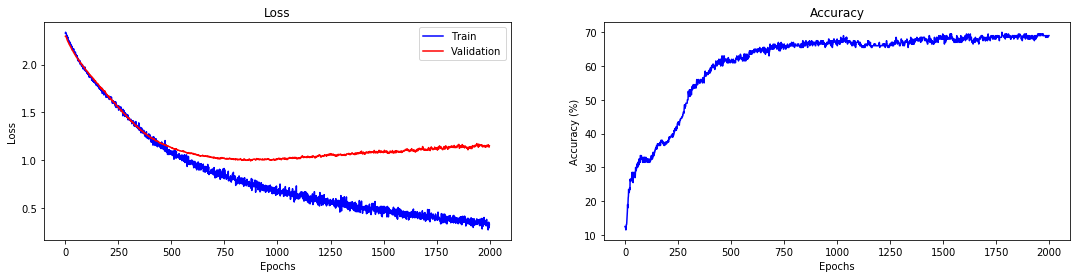

In [34]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [35]:
torch.save(model.state_dict(), './results/mgc_dnn_d_bn.model')

In [42]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 136/200 (68%)

